In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # Replace ValueWarning with UserWarning
# Create an instance of RandomOverSampler
ros = RandomOverSampler(random_state=0)

# Load processed data from a new CSV file
processed_file_path = '/Users/sdong/phd_doc/dataset/processed_human_activities.csv'
windowed_data = pd.read_csv(processed_file_path)

# Extract data for user 1
user1_data = windowed_data[windowed_data['user'] <= 3]
X_user1 = user1_data[['x_mean', 'y_mean', 'z_mean']]
y_user1 = user1_data['activity']

# Split user 1's data into training and validation sets
X_train_user1, X_test_user1, y_train_user1, y_test_user1 = train_test_split(X_user1, y_user1, test_size=0.5, random_state=0)

# Train a Random Forest model
model_rf_baseline6 = RandomForestClassifier(n_estimators=10,max_depth=4, random_state=0)
# Balance the training dataset using the oversampler
X_train_user1_balanced, y_train_user1_balanced = ros.fit_resample(X_train_user1, y_train_user1)
model_rf_baseline6.fit(X_train_user1_balanced, y_train_user1_balanced)

# Prepare data for other users
other_users_data = windowed_data[windowed_data['user'] > 3]
X_other_users = other_users_data[['x_mean', 'y_mean', 'z_mean']]
y_other_users = other_users_data['activity']


# Evaluate the model on the validation set
y_pred_user1 = model_rf_baseline6.predict(X_test_user1)
accuracy = accuracy_score(y_test_user1, y_pred_user1)
print(f'Accuracy on User 1 validation set: {accuracy}')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Relabel prediction results: data predicted incorrectly as 1, correctly as 0
y_new_labels = (y_pred_user1 != y_test_user1).astype(int)

# Calculate the proportion of labels 0 and 1
proportion_label_0 = (y_new_labels == 0).mean()
proportion_label_1 = (y_new_labels == 1).mean()

# Print proportions
print(f"Proportion of label 0: {proportion_label_0:.2f}, label 1: {proportion_label_1:.2f}")

# Use a decision tree with default parameters
decision_tree_default = DecisionTreeClassifier(random_state=16)
decision_tree_default.fit(X_test_user1, y_new_labels)

y_pred_dt_default = decision_tree_default.predict(X_test_user1)
accuracy_dt_default = accuracy_score(y_new_labels, y_pred_dt_default)

#print(f"Accuracy with GridSearchCV: {accuracy_dt_gs}")
print(f"Accuracy with Default Parameters: {accuracy_dt_default}")


import time  # Import time module

# Initialize counter and time accumulator
retrain_count = 0
total_retrain_time = 0

accuracies_baseline6 = []
selected_samples_accuracies = []
train_accuracies = []
error_ratios = []
# Define thresholds
GROWTH_THRESHOLD = 0  # Growth threshold
PROPORTION_THRESHOLD = 0.0  # Proportion threshold

# Prepare cumulative data for updating Baseline 6
cumulative_X_train_baseline6 = X_train_user1.copy()
cumulative_y_train_baseline6 = y_train_user1.copy()


# Function: Extract conditions of branches predicting 1 from the decision tree
def extract_decision_paths(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i >= 0 else "undefined!"
        for i in tree_.feature
    ]
    paths = []

    def recurse(node, path_conditions):
        if tree_.feature[node] >= 0:  # Not a leaf node
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], path_conditions + [(name, "<=", threshold)])
            recurse(tree_.children_right[node], path_conditions + [(name, ">", threshold)])
        else:
            if tree_.value[node][0][1] > tree_.value[node][0][0]:  # Node predicts 1
                paths.append(path_conditions)

    recurse(0, [])
    return paths

# Extract conditions of branches predicting 1
decision_paths = extract_decision_paths(decision_tree_default, ['x_mean', 'y_mean', 'z_mean'])


# Calculate if a sample matches a decision path
def sample_matches_path(sample, path):
    return all(sample[feature] <= threshold if condition == "<=" else sample[feature] > threshold
               for feature, condition, threshold in path)

# Function: Calculate proportions of samples matching decision paths
def calculate_path_proportions(data, paths):
    proportions = []
    for path in paths:
        matches = data.apply(lambda x: sample_matches_path(x, path), axis=1)
        proportion = np.mean(matches)
        proportions.append(proportion)
    return proportions


# Loop through each test batch
for i in range(0, other_users_data.shape[0], 500):
    batch = other_users_data.iloc[i:i+500]
    X_test = batch[['x_mean', 'y_mean', 'z_mean']]
    y_test = batch['activity']
    
    y_pred_batch = model_rf_baseline6.predict(X_test)
    accuracy_batch = accuracy_score(y_test, y_pred_batch)
    print(f"Batch {i//500} Accuracy before retrain: {accuracy_batch:.2f}")
    
    # Calculate the distribution proportions of the current training set and test batch
    train_proportions = calculate_path_proportions(cumulative_X_train_baseline6, decision_paths)
    batch_proportions = calculate_path_proportions(X_test, decision_paths)

    # Calculate the overall distribution proportion of the current training set and test batch
    train_matches = cumulative_X_train_baseline6.apply(lambda x: any(sample_matches_path(x, path) for path in decision_paths), axis=1)
    batch_matches = X_test.apply(lambda x: any(sample_matches_path(x, path) for path in decision_paths), axis=1)
    
    train_proportion = train_matches.mean()
    batch_proportion = batch_matches.mean()

    # Calculate growth and proportion
    growth = [batch_prop - train_prop for batch_prop, train_prop in zip(batch_proportions, train_proportions)]
    exceed_growth_threshold = any(g > GROWTH_THRESHOLD for g in growth)
    exceed_proportion_threshold = any(batch_prop > PROPORTION_THRESHOLD for batch_prop in batch


Accuracy on User 1 validation set: 0.7677935943060499
Proportion of label 0: 0.77, label 1: 0.23
Accuracy with Default Parameters: 1.0
Batch 0 Accuracy berfore retrain: 0.31
        x_mean     y_mean    z_mean
2249  1.718500   9.309750  0.462750
2308  2.755750  10.949250 -0.961000
2399  0.135000   6.010000  0.380000
2400  5.701176   5.753235 -2.068529
2401  4.829512   7.939268 -2.910244
...        ...        ...       ...
2742  3.607750   9.081000  1.445459
2743  3.546500   9.215000  1.681091
2744  3.682000   8.996000  1.604817
2745  3.761026   8.956667  1.540496
2746  3.711951   8.975366  1.546076

[178 rows x 3 columns]
2249    5
2308    5
2399    5
2400    1
2401    1
       ..
2742    5
2743    5
2744    5
2745    5
2746    5
Length: 178, dtype: int64
Batch 0: selected samples size: 178, Accuracy: 0.01
Proportion of label 0: 0.83, label 1: 0.17
1301
Accuracy with Default Parameters: 0.09684857801691008
Batch 0 Accuracy berfore retrain: 0.31, after retrain: 0.83
Batch 1 Accuracy ber


KeyboardInterrupt



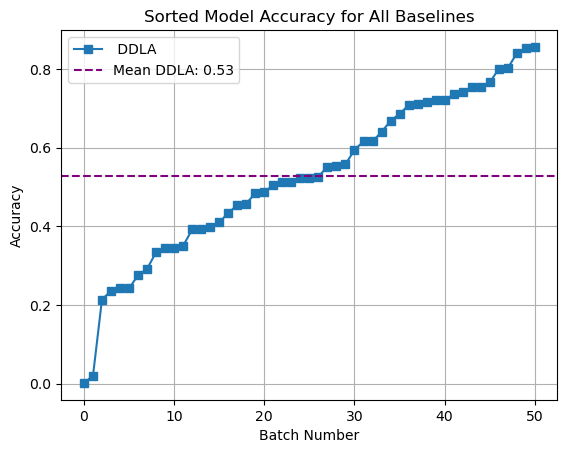

In [10]:
import matplotlib.pyplot as plt


sorted_accuracies_baseline6 = sorted(accuracies_baseline6)


mean_accuracy_baseline6 = sum(sorted_accuracies_baseline6) / len(sorted_accuracies_baseline6)

plt.plot(sorted_accuracies_baseline6, marker='s', label=' DDLA')

plt.axhline(y=mean_accuracy_baseline6, color='purple', linestyle='--', label=f'Mean DDLA: {mean_accuracy_baseline6:.2f}')

plt.title('Sorted Model Accuracy for All Baselines')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
